In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
import keras_tuner
from tensorflow.keras import layers

In [3]:
data_in = np.load("Data/images.npy")
data_out = np.load("Data/labels.npy")

In [15]:
def convert_to_num(hour, minute):
    num = hour+minute/60
    return num

def clock_loss_reg_mse(y_true, y_pred):
    absdiff = K.abs(y_pred - y_true)
    norm_c = absdiff <= 6
    norm_c = tf.cast(norm_c, tf.float32)
    round_c = absdiff > 6
    round_c = tf.cast(round_c, tf.float32)
    normdiff = K.abs(y_pred - y_true)
    rounddiff = 12 - K.abs((y_pred - y_true))
    
    diff = norm_c * normdiff + round_c * rounddiff
    mse = K.mean(diff**2)
    return mse

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

hp = keras_tuner.HyperParameters()

def build_model_cnn(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=16),
        # adding kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
        #activation function
        activation='relu',
        input_shape=[150,150,1],
        padding='same',)
    )
    model.add(
    layers.MaxPooling2D(pool_size = hp.Choice('pool_size', values = [2,3,4]),
    ),
    )
    # Tune the number of layers.
    for i in range(hp.Int("num_cnn_layers", 1, 5)):
        model.add(
            layers.Conv2D(
                #adding filter 
                filters=hp.Int(f'conv_{i}_filter', min_value=32, max_value=640, step=16),
                # adding kernel size
                kernel_size=hp.Choice(f'conv_{i}_kernel', values = [3,5]),
                #activation function
                activation='relu',
                padding='same'),
        )
        model.add(
            layers.MaxPooling2D(
                pool_size = 2
            ),
            )
                
    model.add(layers.Flatten())        

    for i in range(hp.Int("num_dense_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=60, max_value=515, step=20),
                activation=hp.Choice("activation", ["relu", "tanh"]),),
        )
        
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i}', values = [0.25,0.5,0.75])))
    
    model.add(layers.Dense(1, activation="linear"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=clock_loss_reg_mse,
        metrics=[clock_loss_reg_mse],
        run_eagerly=True
    )
    return model

build_model_cnn(keras_tuner.HyperParameters())

In [19]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_cnn,
    objective="val_loss",
    max_trials=30,
    num_initial_points=2,
    seed=90,
    directory="Task_reg",
    project_name="CNN",
    overwrite=True,
    #executions_per_trial,
)

In [20]:
data_in, data_out = unison_shuffled_copies(data_in, data_out)

In [21]:
reg_out = []
for i in range(len(data_out)):
    hour = data_out[i][0]
    minute = data_out[i][1]
    hr_min_num = convert_to_num(hour, minute)
    reg_out.append(hr_min_num)
reg_out = np.array(reg_out)

In [22]:
X_valid, X_train, X_test = data_in[15000: 17000]/np.amax(data_in), data_in[:15000]/np.amax(data_in), data_in[17000:]/np.amax(data_in)
y_valid, y_train, y_test = reg_out[15000: 17000], reg_out[:15000], reg_out[17000:]

In [24]:
tuner.search(X_train, y_train, epochs=150, validation_data=(X_valid, y_valid), 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)], batch_size=150)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
80                |?                 |conv_1_filter
3                 |?                 |conv_1_kernel
3                 |?                 |pool_size
5                 |?                 |num_cnn_layers
368               |?                 |conv_0_filter
3                 |?                 |conv_0_kernel
2                 |?                 |num_dense_layers
140               |?                 |units_0
tanh              |?                 |activation
False             |?                 |dropout
0.00019559        |?                 |lr
32                |?                 |conv_2_filter
3                 |?                 |conv_2_kernel
32                |?                 |conv_3_filter
3                 |?                 |conv_3_kernel
32                |?                 |conv_4_filter
3                 |?                 |conv_4_kernel
60                |?                 |units_1

Epoch 1/150
100

In [28]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=(5,5), strides=1, 
                        activation='relu', input_shape=[150,150,1]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(512, kernel_size=(3,3), strides=1, activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2,2)),
    #keras.layers.Conv2D(640, kernel_size=2, strides=1, activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2,2)),
    #keras.layers.Conv2D(768, kernel_size=2, strides=1, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

In [17]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', 
                        input_shape=[150,150,1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4)
])
'''

"\nmodel = keras.models.Sequential([\n    keras.layers.Conv2D(64, 7, activation='relu', padding='same', \n                        input_shape=[150,150,1]),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),\n    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),\n    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),\n    keras.layers.MaxPooling2D(2),\n    keras.layers.Flatten(),\n    keras.layers.Dense(128, activation='relu'),\n    keras.layers.Dropout(0.5),\n    keras.layers.Dense(64, activation='relu'),\n    keras.layers.Dropout(0.5),\n    keras.layers.Dense(4)\n])\n"

In [29]:
opt = keras.optimizers.SGD(learning_rate=0.001)

In [31]:
model.compile(loss=clock_loss_reg_mse, optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                   validation_data=(X_valid, y_valid))

Epoch 1/20
469/469 [==============================] - 13s 27ms/step - loss: 12.8689 - accuracy: 0.0015 - val_loss: 12.2687 - val_accuracy: 6.6667e-04
Epoch 2/20
469/469 [==============================] - 12s 26ms/step - loss: 14.3976 - accuracy: 0.0016 - val_loss: 12.1171 - val_accuracy: 6.6667e-04
Epoch 3/20
469/469 [==============================] - 12s 26ms/step - loss: 12.3218 - accuracy: 0.0019 - val_loss: 12.2465 - val_accuracy: 6.6667e-04
Epoch 4/20
469/469 [==============================] - 12s 26ms/step - loss: 12.1243 - accuracy: 0.0015 - val_loss: 12.2476 - val_accuracy: 6.6667e-04
Epoch 5/20
469/469 [==============================] - 12s 26ms/step - loss: 12.6568 - accuracy: 0.0014 - val_loss: 12.2467 - val_accuracy: 6.6667e-04
Epoch 6/20
469/469 [==============================] - 12s 26ms/step - loss: 13.2911 - accuracy: 0.0019 - val_loss: 12.1598 - val_accuracy: 6.6667e-04
Epoch 7/20
469/469 [==============================] - 12s 26ms/step - loss: 12.0229 - accuracy: 0.00

In [32]:
model.evaluate(X_train[:10], y_valid[:10])


1/1 [==============================] - 0s 432ms/step - loss: 10.7332 - accuracy: 0.0000e+00


[10.733247756958008, 0.0]

In [36]:
y_pred = model.predict(X_valid)
clock_loss_reg_mse(y_valid,y_pred)cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul]

94/94 [==============================] - 1s 8ms/step


InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul]

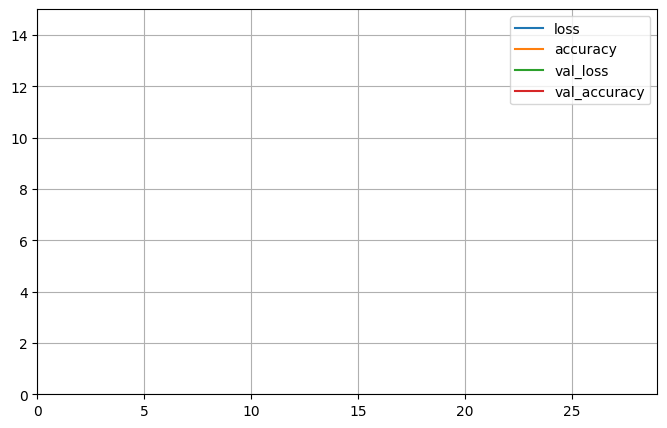

In [21]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,15) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()